In [1]:
import pandas as pd
%reload_ext watermark
%matplotlib inline

import os
import scipy.stats
import yaml
from metapool.metapool import *
from metapool.util import (
    join_dfs_from_files, extend_sample_accession_df,
    extend_compression_layout_info, QIITA_STUDY_ID_KEY)
from metapool.plate import PlateReplication
from metapool import (add_controls, compress_plates, 
                      TUBECODE_KEY, SAMPLE_NAME_KEY, SAMPLE_DNA_CONC_KEY, 
                      NORMALIZED_DNA_VOL_KEY)
from metapool.mp_strings import (
    PM_SAMPLE_KEY, PM_WELL_KEY, PM_LIB_WELL_KEY, TELLSEQ_BARCODE_ID_KEY, 
    TELLSEQ_BARCODE_SET_ID_KEY, EXTRACTED_GDNA_CONC_KEY)
from metapool.util import warn_if_fp_exists
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-12-04T16:56:40.768912-08:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.221.gd899203
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

json      : 2.0.9
matplotlib: 3.9.0
yaml      : 6.0.1
numpy     : 2.0.0
seaborn   : 0.13.2
pandas    : 2.2.2
scipy     : 1.13.1
re        : 2.2.1



In [2]:
! conda list

# packages in environment at /Applications/miniconda3/envs/metapool:
#
# Name                    Version                   Build  Channel
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hdc70f33_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
biom-format               2.1.16                   pypi_0  

# Knight Lab TellSeq pipeline notebook

## Part 1 (of 5): Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise sample accession file that indicates the sample name (`sample_name`) and its associated matrix tube barcode (`TubeCode`)
2. A tab-delimited metadata file downloaded from Qiita
3. An accurate plate compression form, with appropriate VisionMate barcode scanner files (`Plate map file`)
4. One or more DNA concentration files: at least one for the undiluted plate, and as many additional ones for other dilutions as desired.

The workflow then:
1. reads in the specified input files and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity, with info on which samples need to be pulled from the diluted plate and which from the original plate
3. produces an Echo-formatted pick list file
4. outputs a plate file and a studies info file for use in later notebooks

### Part 1 of 5, Step 0 of 8: Provide inputs

In [3]:
## INPUT
expt_name = "RKLtest"

In [4]:
## INPUT
# One dictionary per study included in the samples on this run.
studies_info = [
    # EVERY entry in the dictionary must be specifically updated 
    # *every* time this notebook is run--none of these have defaults!
    {
    'Project Name': 'Wellcome_Leap_15538', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'WellcomeLeap', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/Tellseq_Wellcome Leap - 15538 - Sample Accession.csv',
    'qiita_metadata_fp': './test_data/Plate_Maps/15538_20241004-110731.txt',
    'experiment_design_description': 'plasma sequencing',
    'HumanFiltering': 'True', 
    'Email': 'r@gmail.com'
    }  
]

In [5]:
## INPUT
# TODO: ask what you put in here when doing replicates
compression_layout = [
    {
        # top left plate
        'Plate Position': 1, # as int
        'Plate map file': './test_data/Plate_Maps/Tellseq_Test_Plate_1.tsv',
        'Project Name': 'Wellcome_Leap_15538', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_1', # Plate_#
        'Plate elution volume': 70
    },
    {
        # top right plate
        'Plate Position': 2, # as int
        'Plate map file': './test_data/Plate_Maps/Tellseq_Test_Plate_2.tsv',
        'Project Name': 'Wellcome_Leap_15538', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_2', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom left plate
        'Plate Position': 3, # as int
        'Plate map file': './test_data/Plate_Maps/Tellseq_Test_Plate_3.tsv',
        'Project Name': 'Wellcome_Leap_15538', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_3', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom right plate
        'Plate Position': 4, # as int
        'Plate map file': './test_data/Plate_Maps/Tellseq_Test_Plate_4.tsv',
        'Project Name': 'Wellcome_Leap_15538', # PROJECTNAME_QIITAID 
        'Project Plate': 'Plate_4',  # Plate_#
        'Plate elution volume': 70
    },
]

In [6]:
# CONSTANTS: Users, DO NOT CHANGE THESE
# values without consulting with tech team

# Mask arrays for even and odd rows and columns
EVEN_ROWS = [x for x in range(16) if x % 2 == 0]
ODD_ROWS = [x for x in range(16) if x % 2 == 1]
EVEN_COLS = [x for x in range(24) if x % 2 == 0]
ODD_COLS = [x for x in range(24) if x % 2 == 1]

In [7]:
def get_studies_attr_list(studies_dict, desired_key):
    return [x[desired_key] for x in studies_dict]

def pick_expected_separator(fps_list):
    sep = "\t"
    visible_sep = "tab"
    
    num_fps = len(fps_list)
    num_csv = sum([x.endswith('.csv') for x in fps_list])
    num_txt = sum([x.endswith('.txt') for x in fps_list])
    num_tsv = sum([x.endswith('.tsv') for x in fps_list])
    
    if num_csv == num_fps:
        sep = ','
        visible_sep = "comma"
    elif (num_tsv + num_txt) != num_fps:
        warnings.warn(
            "Could not determine separator; defaulting to " + visible_sep)

    return sep, visible_sep

### Part 1 of 5, Step 1 of 8: Read in sample accession files

In [8]:
# read in the sample accession files
sample_accession_fps = get_studies_attr_list(
    studies_info, 'sample_accession_fp')
sample_acc_sep, sa_sep_name = pick_expected_separator(sample_accession_fps)
print(f"Expected sample accession separator: {sa_sep_name}")

Expected sample accession separator: comma


In [9]:
sample_accession_df = join_dfs_from_files(
    sample_accession_fps, [SAMPLE_NAME_KEY, TUBECODE_KEY], sep=sample_acc_sep)
sample_accession_df.shape

(783, 2)

In [10]:
sample_accession_df.head()

,sample_name,TubeCode
0,01LJ00482.V5,359190319
1,01LJ01597.V8,359190318
2,01LJ02862.V5,359190311
3,01LJ04192.V5,359190315
4,01LJ04877.V8,359190310


### Part 1 of 5, Step 2 of 8: Read in the sample info from Qiita

In [11]:
# read in the qiita metadata files
qiita_metadata_fps = get_studies_attr_list(studies_info, 'qiita_metadata_fp')
qiita_metadata_sep, qm_sep_name = pick_expected_separator(qiita_metadata_fps)
print(f"Expected qiita metadata separator: {qm_sep_name}")

Expected qiita metadata separator: tab


In [12]:
metadata_df = join_dfs_from_files(
    qiita_metadata_fps, [SAMPLE_NAME_KEY, QIITA_STUDY_ID_KEY], 
    opt_cols_to_extract=['tube_id'], unique_cols=[SAMPLE_NAME_KEY],
    sep=qiita_metadata_sep)
metadata_df.shape

(864, 3)

In [13]:
metadata_df.head()

,sample_name,qiita_study_id,tube_id
0,15538.01LJ00012.V10,15538,359190313
1,15538.01LJ00012.V5,15538,359190256
2,15538.01LJ00012.V8,15538,359190309
3,15538.01LJ00016.V10,15538,359190597
4,15538.01LJ00016.V5,15538,359190302


Now use the metadata to link the study info into the sample accession dataframe:

In [14]:
extended_sample_accession_df = extend_sample_accession_df(
    sample_accession_df, studies_info, metadata_df)
extended_sample_accession_df.head()

,sample_name,TubeCode,Project Name,Project Abbreviation
0,01LJ00482.V5,359190319,Wellcome_Leap_15538,WellcomeLeap
1,01LJ01597.V8,359190318,Wellcome_Leap_15538,WellcomeLeap
2,01LJ02862.V5,359190311,Wellcome_Leap_15538,WellcomeLeap
3,01LJ04192.V5,359190315,Wellcome_Leap_15538,WellcomeLeap
4,01LJ04877.V8,359190310,Wellcome_Leap_15538,WellcomeLeap


### Part 1 of 5, Step 3 of 8: Assign the compression layout and add controls

In [15]:
## INPUT
blanks_dir = './test_data/BLANKS_for_tellseq'

## INPUT
# ATTENTION: Does your plate include katharoseq controls?
# If *yes*, replace the None below with the path to the directory they are in, such as
# katharoseq_dir = './test_data/katharoseq'
katharoseq_dir = None

In [16]:
# copy study info into the compression layout dictionary (so that it doesn't 
# have to be entered manually in both places)
extended_compression_layout = extend_compression_layout_info(
    compression_layout, studies_info)

In [17]:
plate_df = compress_plates(extended_compression_layout, 
                           extended_sample_accession_df, well_col=PM_WELL_KEY)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96
0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,93522,359190319,A1,70,A1
1,01LJ00482.V8,2,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,93522,359190312,A3,70,A2
2,01LJ00482.V10,3,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,93522,359190294,A5,70,A3
3,01LJ00514.V8,4,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,93522,359190273,A7,70,A4
4,01LJ00514.V10,5,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,93522,359190284,A9,70,A5


Check for samples with missing names; at this point, we expect all blanks
and katharoseq controls WON'T have names.

In [18]:
def check_nan_samples(a_plate_df, a_blanks_dir=None):
    num_remaining_nans = a_plate_df[a_plate_df[PM_SAMPLE_KEY].isna()].shape[0]
    print("Number of samples with missing names: %d" % num_remaining_nans)
    
    if num_remaining_nans > 0 and a_blanks_dir:
        err_msg = f"""
By now, all samples should have names, so **do not continue** before fixing this!

"Unofficial" blanks are the most likely issue.
Determine if the tube codes for the problem samples (shown below) are blanks.
If they are, add them to the missing_blanks.csv file in the {a_blanks_dir} directory.
Then re-run from 'Part 1 of 5, Step 3 of 8: Assign the compression layout and add controls'."""
        print(err_msg)

In [19]:
check_nan_samples(plate_df)

Number of samples with missing names: 32


In [20]:
plate_df = add_controls(plate_df, blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2061: UserWarning: Controls added
  warnings.warn("Controls added")


After adding controls, check again for samples with missing names; 
at this point, we expect all blanks and katharoseq controls WILL have names, 
so if there are any remaining samples without names, 
stop processing and fix them!

In [21]:
## DECISION -- stop if there are still samples without names
check_nan_samples(plate_df, a_blanks_dir=blanks_dir)
plate_df[plate_df[PM_SAMPLE_KEY].isna()]

Number of samples with missing names: 0


,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank


### Part 1 of 5, Step 4 of 8: Validate plate dataframe

In [22]:
# note that this function does not *need* the extended sample accession df,
# but it is easier to use it just to keep things consistent
validate_plate_df(plate_df,metadata_df, extended_sample_accession_df, 
                  blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2168: UserWarning: There are 32 control samples in this plate
  warnings.warn(f"There are {len(control_samples)} control samples"
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2179: UserWarning: There are 352 samples with associated metadata in this plate
  warnings.warn(
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2189: UserWarning: All samples have associated metadata :D
  warnings.warn("All samples have associated metadata :D")
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2224: UserWarning: All TubeCodes have associated data :D
  warnings.warn("All TubeCodes have associated data :D")


### Part 1 of 5, Step 5 of 8: read in DNA concentrations and add to plate map

Enter the path to each of the Pico DNA concentration output files. Each one should be
 a tab-separated file produced by the MiniPico assay on the condensed, 
 384-well plate, and should have a format like the below:

```
##BLOCKS= 1
Group: Unknowns
Sample	Wells	RFU_Values	Concentration	Mean_Conc	SD	CV	Dilution	AdjConc	
01	A1	528791.000	2.472	2.472	0.000	0.0			
02	C1	481728.000	2.282	2.282	0.000	0.0			
03	E1	462964.000	2.206	2.206	0.000	0.0			
04	G1	556609.000	2.585	2.585	0.000	0.0			
05	I1	710679.000	3.207	3.207	0.000	0.0			
06	K1	655693.000	2.985	2.985	0.000	0.0		
```

In [23]:
UNDILUTED_NAME = 'undiluted'

In [24]:
## INPUT
# Add one entry for each dilution, where the key is a descriptive name
# for the dilution and the value is the path to the concentrations file.  
# Order from most to least preferred for use.

## IMPORTANT: The undiluted file must be the LAST ONE, named with
# UNDILUTED_NAME

dilutions_infos = {
    "10to1dilution": './test_data/Quant/MiniPico/Tellseq_gDNA_diluted_10_to_1_Quant.txt',
    "2to1dilution": './test_data/Quant/MiniPico/Tellseq_gDNA_diluted_2_to_1_Quant.txt',
    UNDILUTED_NAME: './test_data/Quant/MiniPico/Tellseq_gDNA_Original_Quant.txt'
}

In [25]:
for curr_fp in dilutions_infos.values():
    if not os.path.isfile(curr_fp):
        print("Problem! %s is not a path to a valid file" % curr_fp)

In [26]:
def read_agnostic_pico_csv(a_fp, name_suffix, plate_reader):
    a_df = read_pico_csv(a_fp, plate_reader=plate_reader)
    suffixed_names = {x: f"{x}_{name_suffix}" for x in a_df.columns}
    suffixed_names.pop(PM_WELL_KEY)  # Don't actually want to rename that :)
    a_df.rename(columns=suffixed_names, inplace=True)
    return a_df

def load_concentrations(plate_df, conc_dict, plate_reader):
    a_df = plate_df.copy()
    for curr_dilution_suffix, curr_conc_fp in conc_dict.items():
        curr_conc_df = read_agnostic_pico_csv(
            curr_conc_fp, curr_dilution_suffix, plate_reader=plate_reader)
        a_df = pd.merge(a_df, curr_conc_df, on=PM_WELL_KEY)
    # next dilution suffix
    return a_df

In [27]:
plate_df = load_concentrations(plate_df, dilutions_infos, 'SpectraMax_i3x')
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration_10to1dilution,Sample DNA Concentration_2to1dilution,Sample DNA Concentration_undiluted
0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,...,70,A1,NaN,NaN,NaN,NaN,False,1.1712,5.8560,11.712
1,01LJ00482.V8,2,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,...,70,A2,NaN,NaN,NaN,NaN,False,1.4294,7.1470,14.294
2,01LJ00482.V10,3,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,...,70,A3,NaN,NaN,NaN,NaN,False,1.9047,9.5235,19.047
3,01LJ00514.V8,4,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,...,70,A4,NaN,NaN,NaN,NaN,False,2.7218,13.6090,27.218
4,01LJ00514.V10,5,Wellcome_Leap_15538_1_2_3_4,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1,Wellcome_Leap_Plate_1,A,...,70,A5,NaN,NaN,NaN,NaN,False,2.2552,11.2760,22.552


In [28]:
## INPUT -- verify default
# Add dilution info into the plate df; for every sample with a DILUTED 
# concentration greater than or equal to the min concentration threshold, we
# SHOULD use the diluted plate values.
min_conc_threshold = 1.5  # ng/ul

In [29]:
def make_conc_col_name(dilution_name):
    return f"{SAMPLE_DNA_CONC_KEY}_{dilution_name}"

def get_gte_thresh_mask(a_plate_df, conc_key, threshold):
    return a_plate_df[conc_key] >= threshold

def select_sample_dilutions(
        a_plate_df, dilution_suffixes_in_order, a_mask_func):
    """
        Reads a plate_df and sets info for samples that need dilution.
        :param a_plate_df: processing-plate Pandas dataframe
        :param dilution_suffixes_in_order: A list of strings, each of which is
            a suffix used to identify a set of concentration values and
            associated plates. MUST be ordered by decreasing preference, with
            the UNDILUTED case as the last element.
        :param a_mask_func: a function that takes in a plate_df and a 
            concentration column name for a particular dilution and returns 
            a mask indicating which samples to include from this dilution.
        :return: Pandas DataFrame
               Note: 'Diluted' column will be added and contents set to 'True'.
    """

    if 'Diluted' in a_plate_df.columns:
        # function has already been applied to data
        warnings.warn('Dilution operation was already performed')
        return a_plate_df

    # return a copy of the input data. Do not overwrite input data by default.
    df = a_plate_df.copy()

    # first time through the loop is the undiluted case
    is_undiluted = True

    # loop over the dictionary keys/items in reverse order
    reverse_order_keys = list(reversed(dilution_suffixes_in_order))
    for curr_dilution_suffix in reverse_order_keys:
        curr_conc_key = make_conc_col_name(curr_dilution_suffix)
        curr_is_undiluted = is_undiluted
        if is_undiluted:
            # set the extracted gdna key for absquant to the undiluted conc
            df[EXTRACTED_GDNA_CONC_KEY] = a_plate_df[curr_conc_key].copy()
            # make a mask including ALL rows; this is the fallback case
            dilution_mask = pd.Series(True, index=df.index)
            # going forward, all future suffixes will be for dilutions
            is_undiluted = False
        else:
            # make a mask for samples with curr concentration >= threshold
            dilution_mask = a_mask_func(a_plate_df, curr_conc_key)
        # endif is_undiluted

        # set the concentration & supporting cols for the qualifying rows
        df.loc[dilution_mask, SAMPLE_DNA_CONC_KEY] = \
            a_plate_df.loc[dilution_mask, curr_conc_key]
        df.loc[dilution_mask, 'Diluted'] = not curr_is_undiluted
        df.loc[dilution_mask, PM_PROJECT_PLATE_KEY] = a_plate_df.loc[
            dilution_mask, PM_PROJECT_PLATE_KEY].astype(str) + "_" + curr_dilution_suffix
        df.loc[dilution_mask, PM_COMPRESSED_PLATE_NAME_KEY] = a_plate_df.loc[
            dilution_mask, PM_COMPRESSED_PLATE_NAME_KEY].astype(str) + "_" + curr_dilution_suffix
    # next dilution_suffix

    return df

In [30]:
plate_df = select_sample_dilutions(
    plate_df, list(dilutions_infos.keys()), 
    lambda x, y: get_gte_thresh_mask(x, y, min_conc_threshold))
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration_10to1dilution,Sample DNA Concentration_2to1dilution,Sample DNA Concentration_undiluted,extracted_gdna_concentration_ng_ul,Sample DNA Concentration,Diluted
0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,A,...,NaN,NaN,NaN,False,1.1712,5.8560,11.712,11.712,5.8560,True
1,01LJ00482.V8,2,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,A,...,NaN,NaN,NaN,False,1.4294,7.1470,14.294,14.294,7.1470,True
2,01LJ00482.V10,3,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,NaN,NaN,NaN,False,1.9047,9.5235,19.047,19.047,1.9047,True
3,01LJ00514.V8,4,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,NaN,NaN,NaN,False,2.7218,13.6090,27.218,27.218,2.7218,True
4,01LJ00514.V10,5,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,NaN,NaN,NaN,False,2.2552,11.2760,22.552,22.552,2.2552,True


**Visualize dilutions:**

In [31]:
preferred_dilution_name = list(dilutions_infos.keys())[0]
undiluted_conc_key = make_conc_col_name(UNDILUTED_NAME) 
diluted_conc_key = make_conc_col_name(preferred_dilution_name)

<Axes: xlabel='Sample DNA Concentration_undiluted', ylabel='Count'>

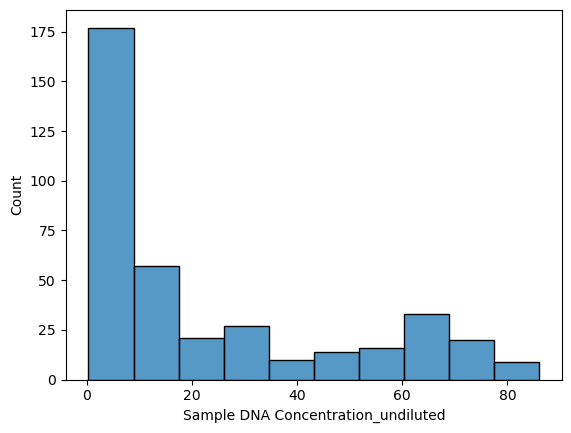

In [32]:
sns.histplot(plate_df[undiluted_conc_key],bins=10)

In [33]:
def plot_dilution_regression(
        a_plate_df, undiluted_name=undiluted_conc_key, 
        diluted_name=diluted_conc_key):
    res = scipy.stats.linregress(plate_df[undiluted_name],plate_df[diluted_name])
    plt.title(f'Calculated dilution factor from regression: {res.slope:.3f}, \n Person correlation: {res.rvalue:.3f}')  
    sns.regplot(x=undiluted_name,y=diluted_name,data=a_plate_df) 

In [34]:
dilution_factor_key = f"dilution_factor_{preferred_dilution_name}"
plate_df[dilution_factor_key] = plate_df[diluted_conc_key]/plate_df[undiluted_conc_key]

In [35]:
def plot_dilution_factor(
        a_plate_df, a_dilution_conc_key, a_dilution_factor_key, use_log_y=True):
    sns.scatterplot(
        x=a_dilution_conc_key,y=a_dilution_factor_key,data=a_plate_df)
    if use_log_y:
        plt.yscale('log')

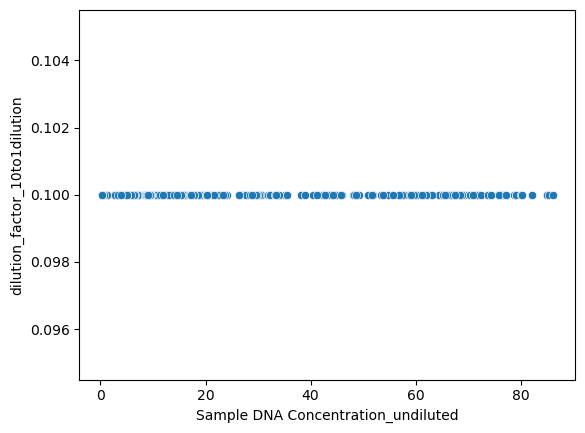

In [36]:
plot_dilution_factor(plate_df, undiluted_conc_key, dilution_factor_key, use_log_y=False)

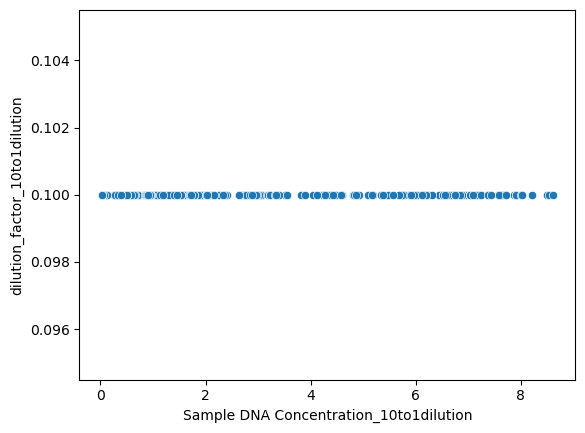

In [37]:
plot_dilution_factor(plate_df, diluted_conc_key, dilution_factor_key, use_log_y=False)

**Visualize plate DNA concentrations and plate map:**

In [38]:
def display_concentration_heatmap(a_plate_df, conc_key, plate_num=None):
    plate_index_sets = {
        1: [EVEN_ROWS, EVEN_COLS],
        2: [EVEN_ROWS, ODD_COLS],
        3: [ODD_ROWS, EVEN_COLS],
        4: [ODD_ROWS, ODD_COLS]
    }
    
    dna_concs = make_2D_array(a_plate_df, data_col=conc_key, 
                              well_col=PM_WELL_KEY).astype(float)
    
    # get information for annotation
    names = make_2D_array(
        a_plate_df, data_col=PM_SAMPLE_KEY, well_col=PM_WELL_KEY)
    
    plot_concs = dna_concs
    plot_names = names
    if plate_num is not None:
        plot_concs = dna_concs[np.ix_(*plate_index_sets[plate_num])]
        plot_names = names[np.ix_(*plate_index_sets[plate_num])]
    
    plot_plate_vals(plot_concs,
                    annot_str=plot_names,
                    color_map='viridis',
                    annot_fmt='.5s')
    
def display_concentration_heatmap_by_dilution(a_plate_df, dilution_name, plate_num=None):
    plate_str = "" if plate_num is None else f" plate {plate_num}"
    print(f"Concentration heatmap for {dilution_name}{plate_str}")
    display_concentration_heatmap(
        a_plate_df, make_conc_col_name(dilution_name), 
        plate_num=plate_num)

Display the 384-well visualization of the most preferred dilution plate and the undiluted plate:

Concentration heatmap for 10to1dilution


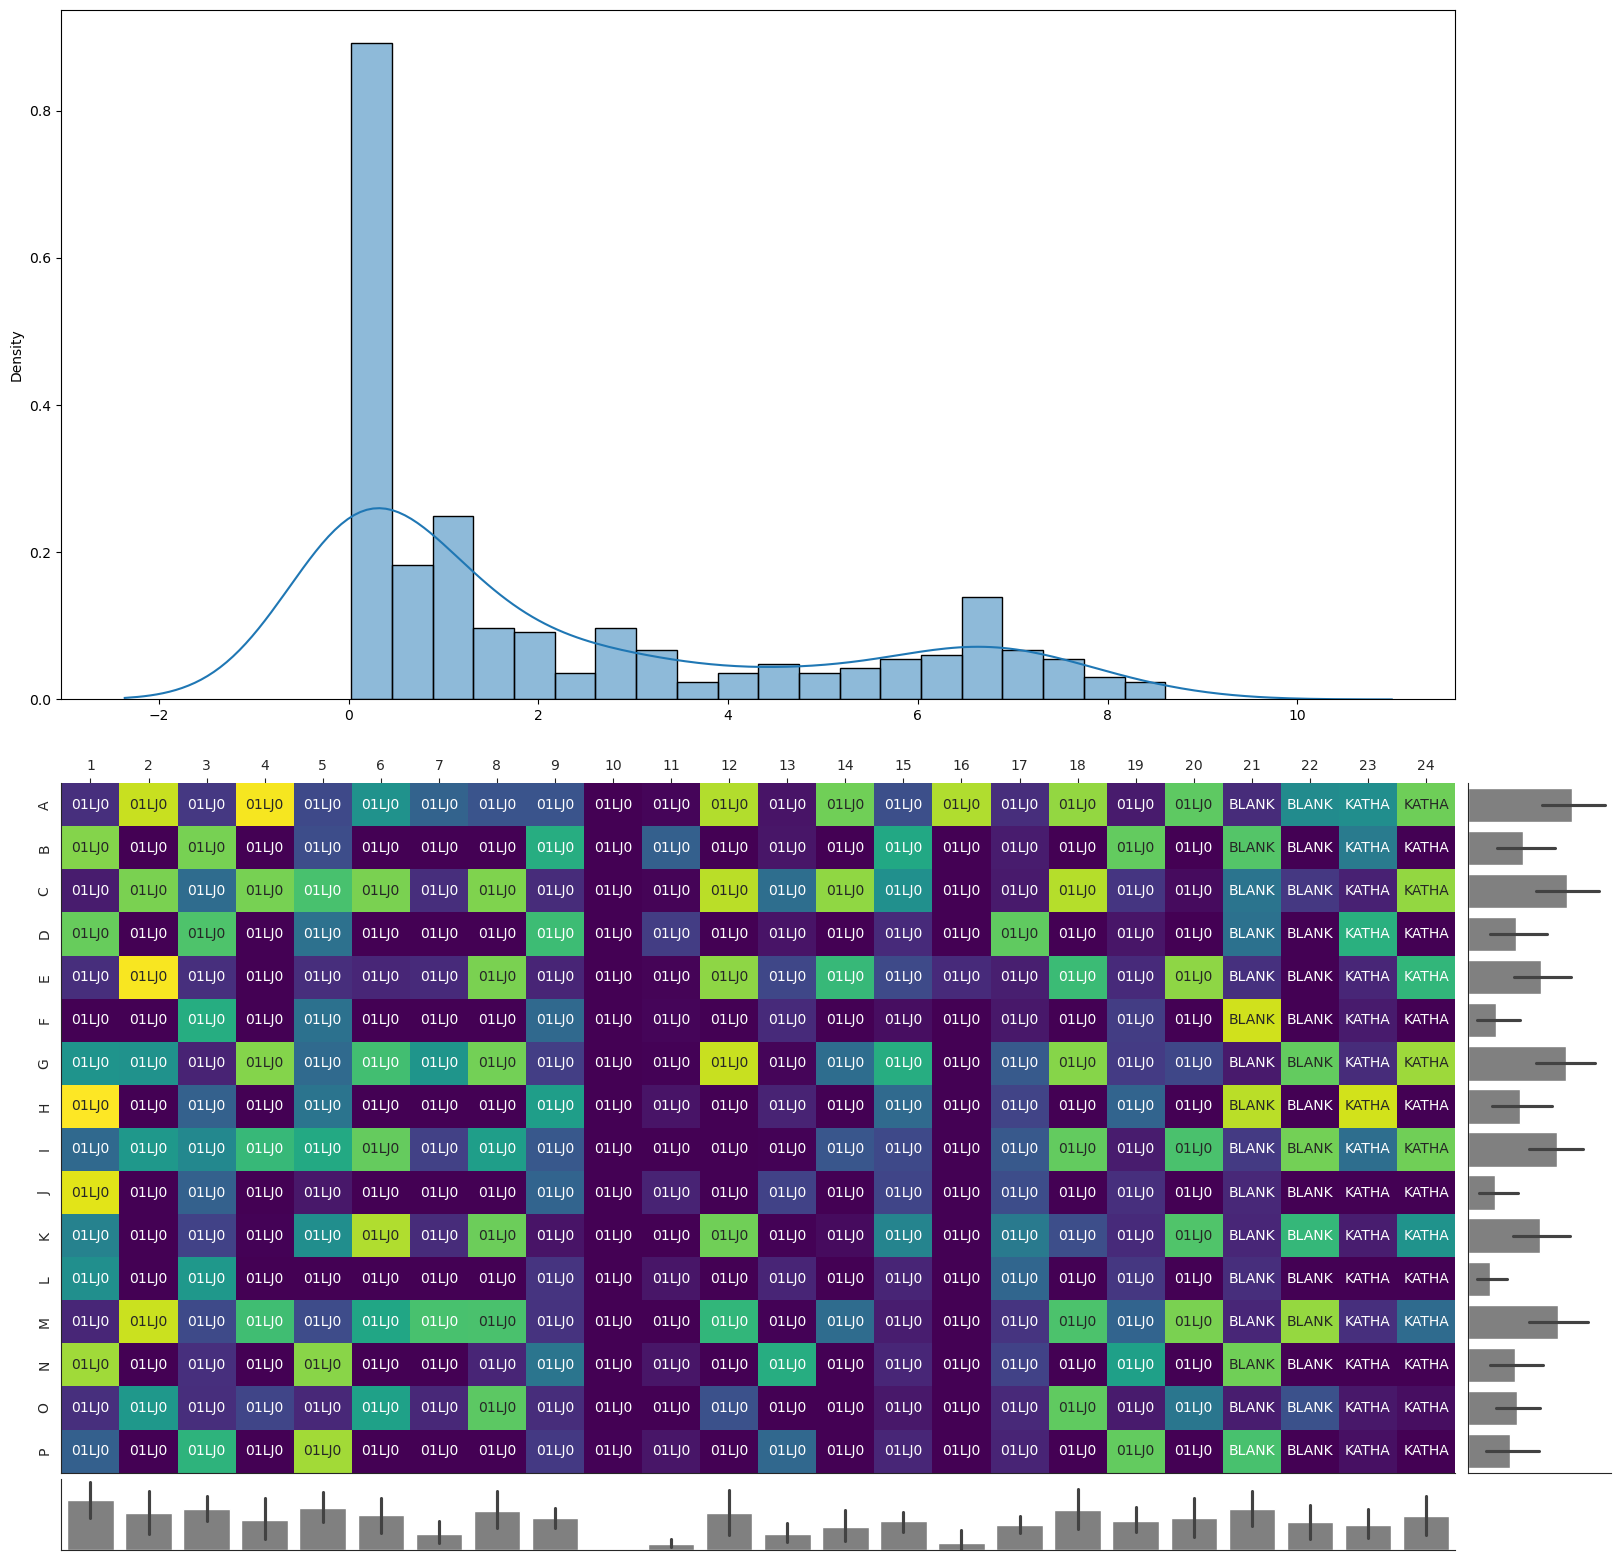

In [39]:
display_concentration_heatmap_by_dilution(plate_df, preferred_dilution_name)

Concentration heatmap for undiluted


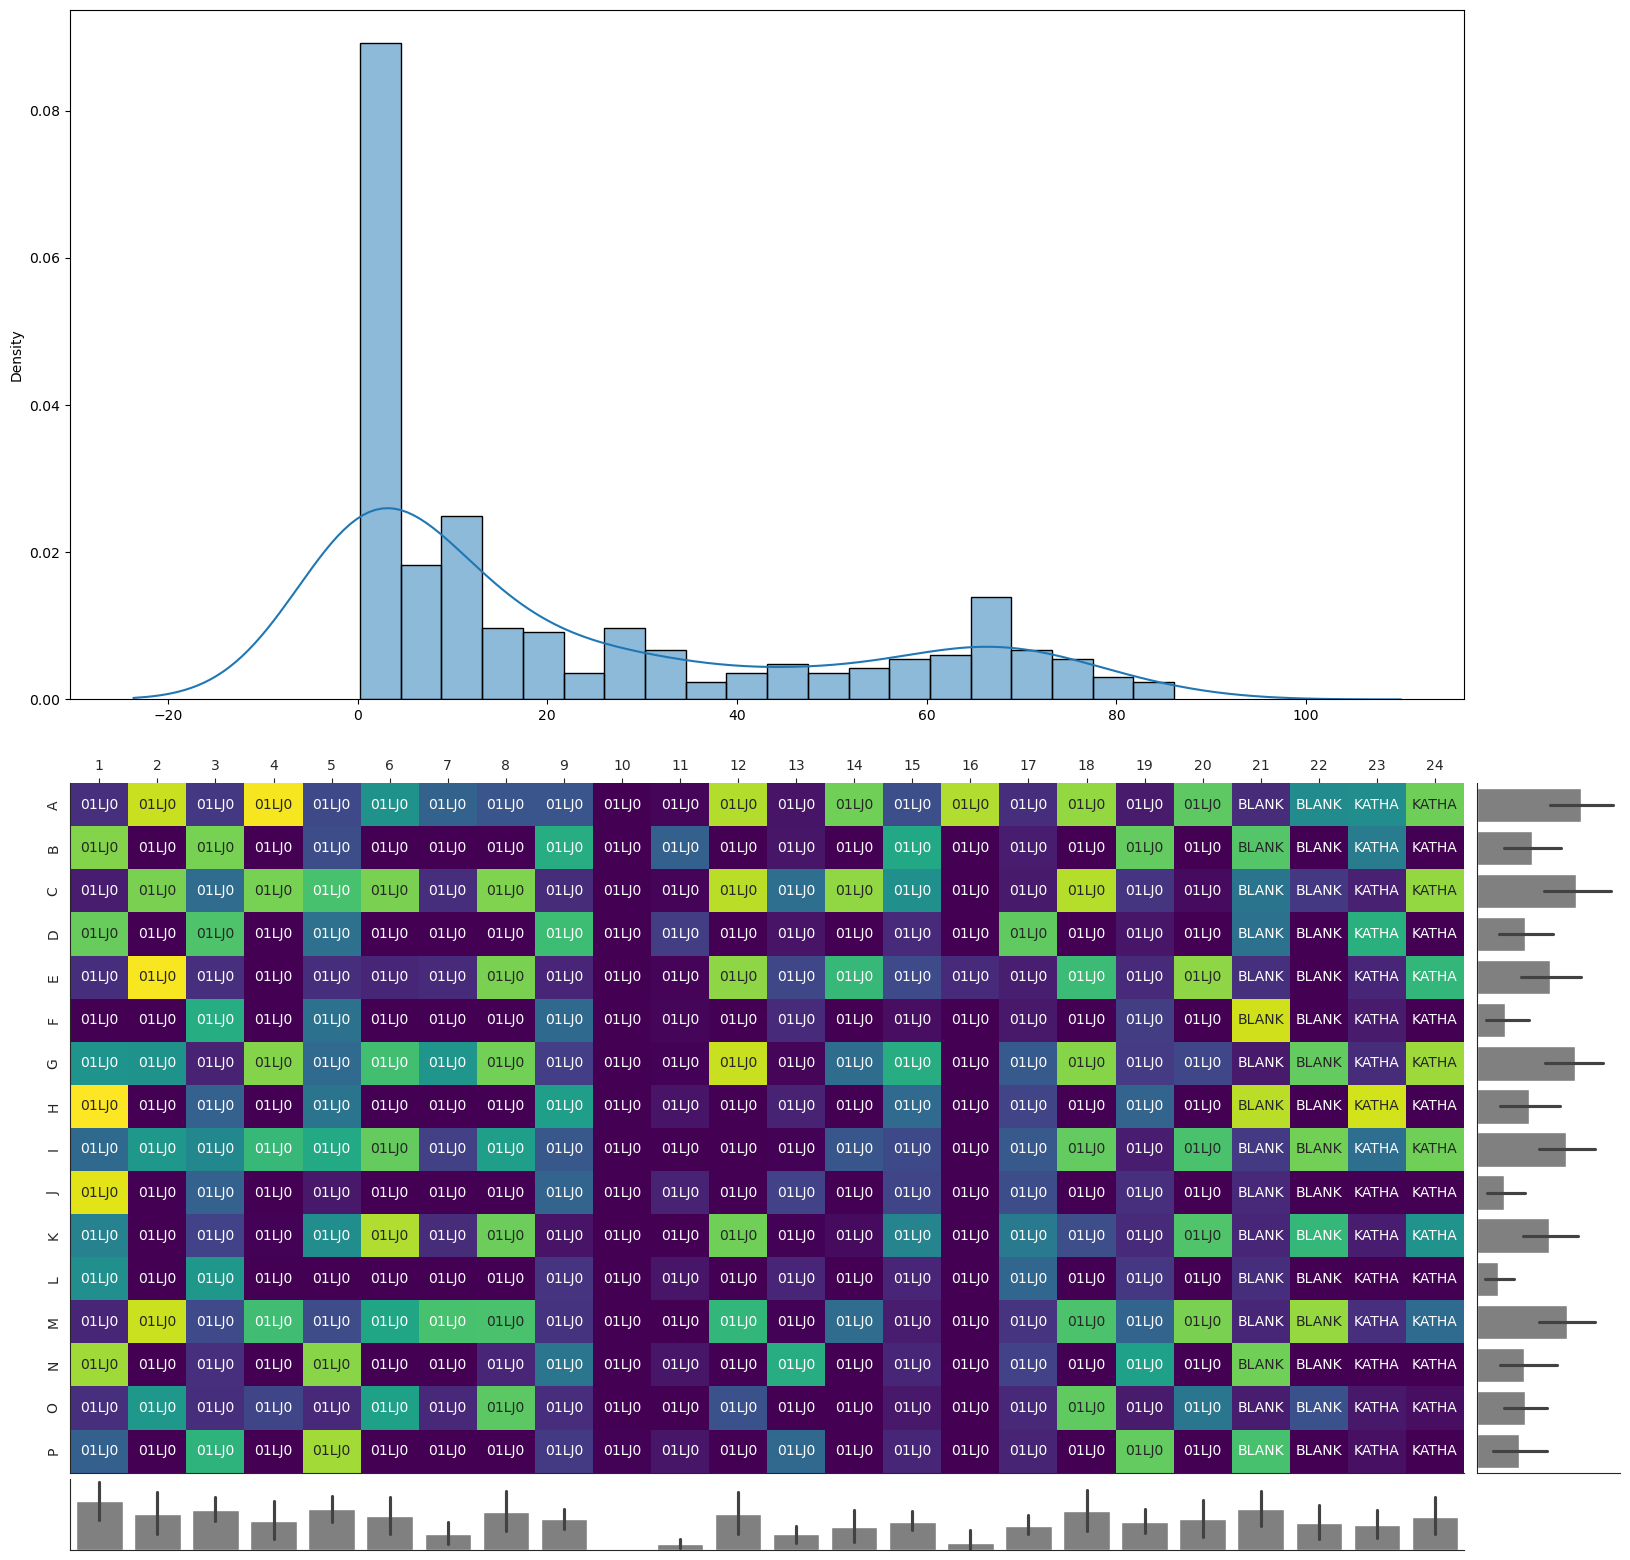

In [40]:
display_concentration_heatmap_by_dilution(plate_df, UNDILUTED_NAME)

#### Make sample replicates

Set replicate dictionary, if needed.

In [41]:
# Replicate formats:
# replicate_dict = {source1_quadrant:destination1_quadrant}
# replicate_dict = {source1_quadrant:[destination1_quadrants,destination1_quadrants]}
# Replicate example: 
# replicate_dict = {1:[2,3]}
# for no replicates, use:
replicate_dict = None

# 'Well' differs from 'Library Well' because the former specifies the 
# gDNA source well while the latter specifies the well (destination well) that 
# will contain the sequencing library for the sample. These contain the same
# info when replicates are not used, but differ when replicates ARE used,
# so it is safer to use 'Library Well' in both cases.
# (Careful!  well_col is a global variable used throughout rest of notebook)
well_col = PM_LIB_WELL_KEY

In [42]:
# initialize new PlateReplication object to manage metadata, conversions, etc.
# initialize w/preferred well_col.
pr = PlateReplication(well_col)

# set overwrite=False to detect any overwriting of source or destination quads 
# and raise an Error.
plate_df = pr.make_replicates(
    plate_df, replicates=replicate_dict, overwrite=True)

# replicates overlapping sample_wells for other samples should raise warning,
# but will be allowed
if 'True' in plate_df['contains_replicates'].unique():
    raise NotImplementedError("This notebook does not yet support replicates.")
    
    # plate_df['contains_replicates'] = True
    # # get DNA concentration information
    # dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', 
    #                           well_col=well_col).astype(float)
    # 
    # # get information for annotation
    # names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)
    # 
    # plot_plate_vals(dna_concs,
    #             annot_str=names,
    #             color_map='viridis',
    #             annot_fmt='.6s')
else:
    plate_df['contains_replicates'] = False
    
# show whether this plate contains replicates or not
f"Contains replicates: {plate_df['contains_replicates'].unique()}"

'Contains replicates: [False]'

#### gDNA concentration heatmap, Plate 1

Concentration heatmap for undiluted plate 1


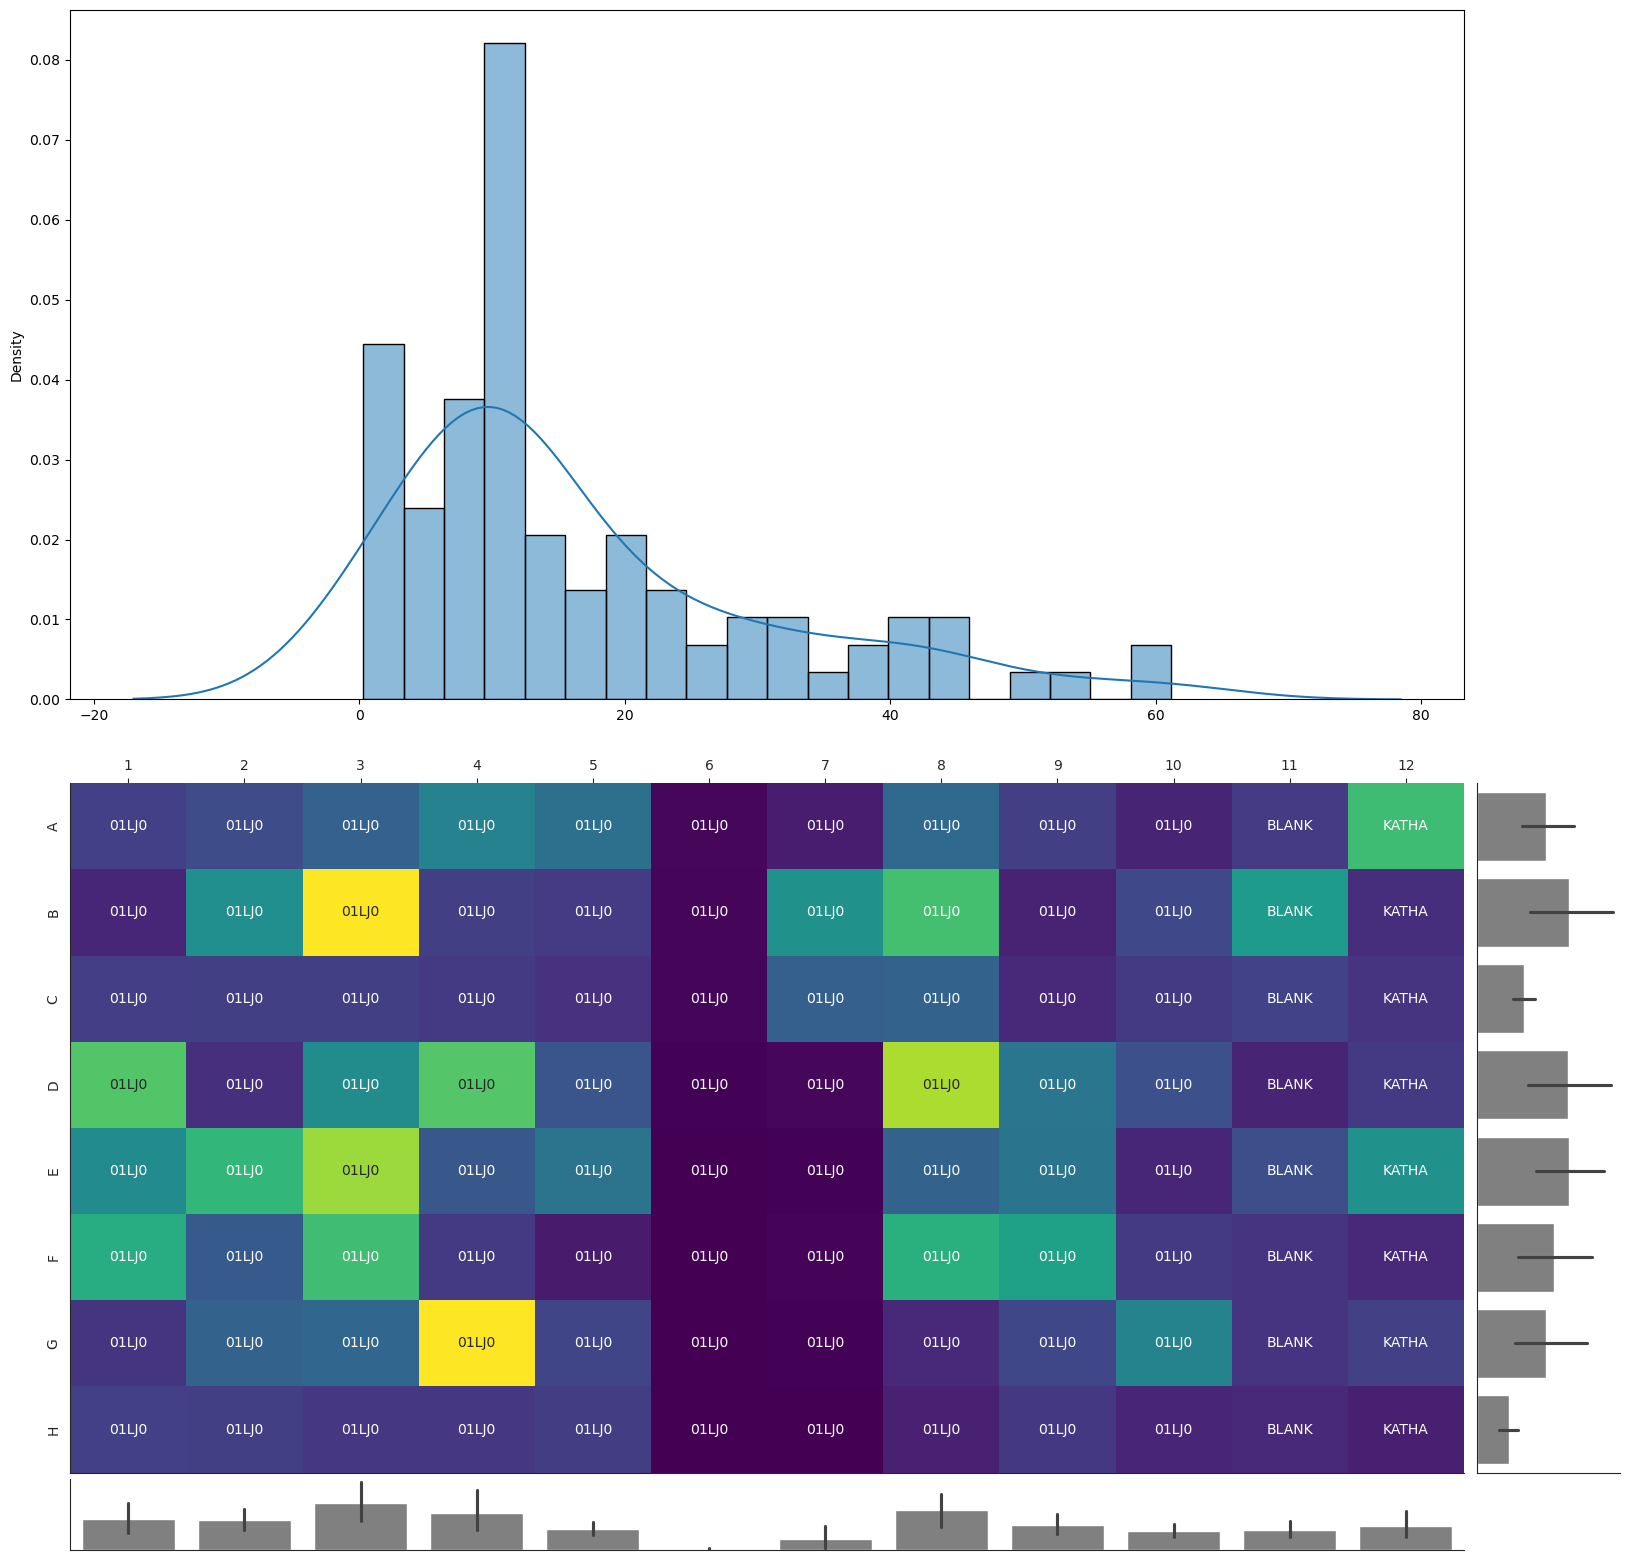

In [43]:
display_concentration_heatmap_by_dilution(plate_df, UNDILUTED_NAME, 1)

#### gDNA concentration heatmap, Plate 2

Concentration heatmap for undiluted plate 2


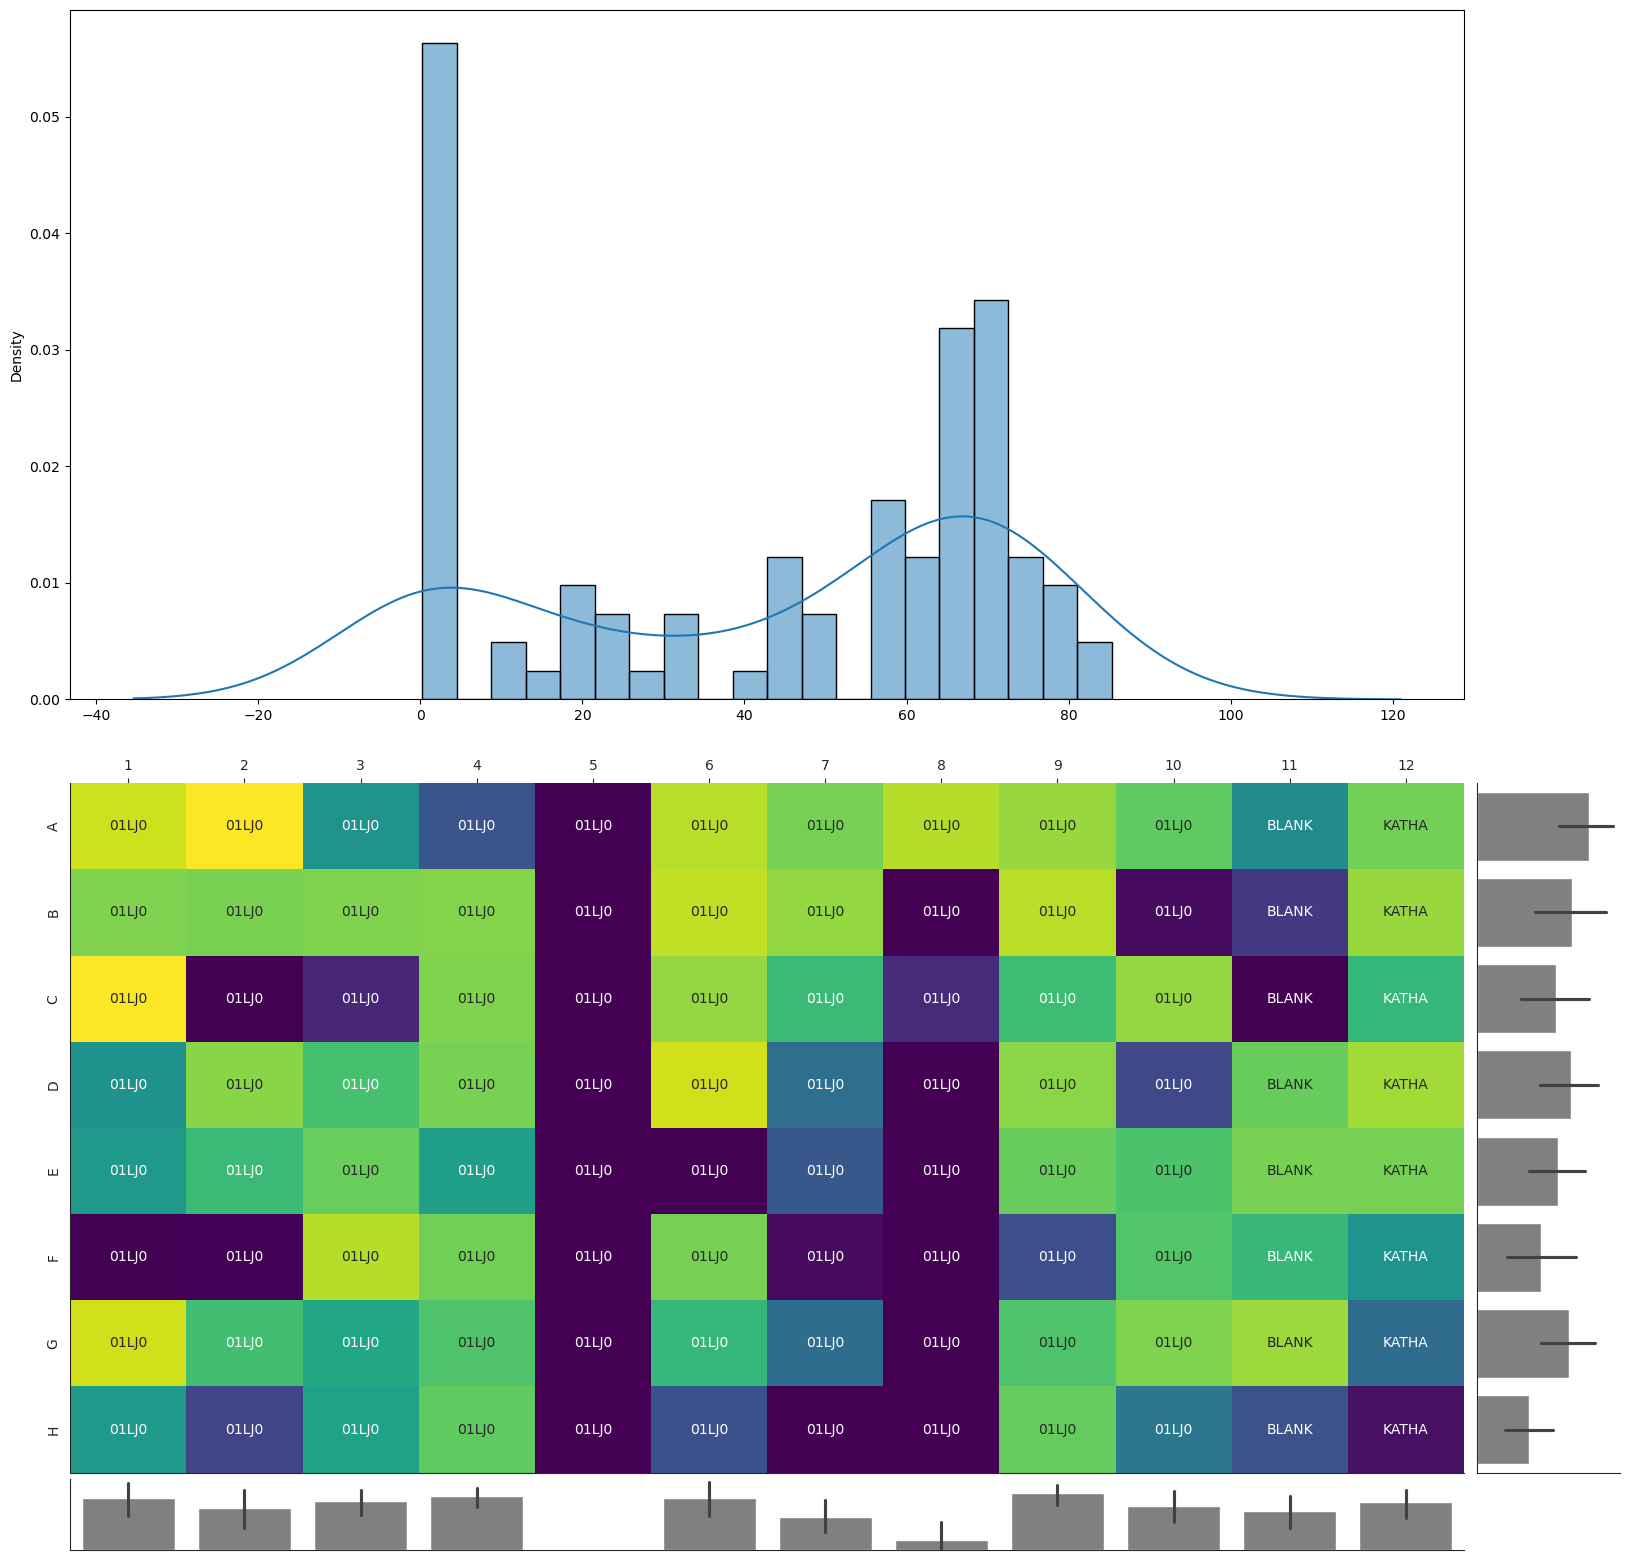

In [44]:
display_concentration_heatmap_by_dilution(plate_df, UNDILUTED_NAME, 2)

#### gDNA concentration heatmap, Plate 3

Concentration heatmap for undiluted plate 3


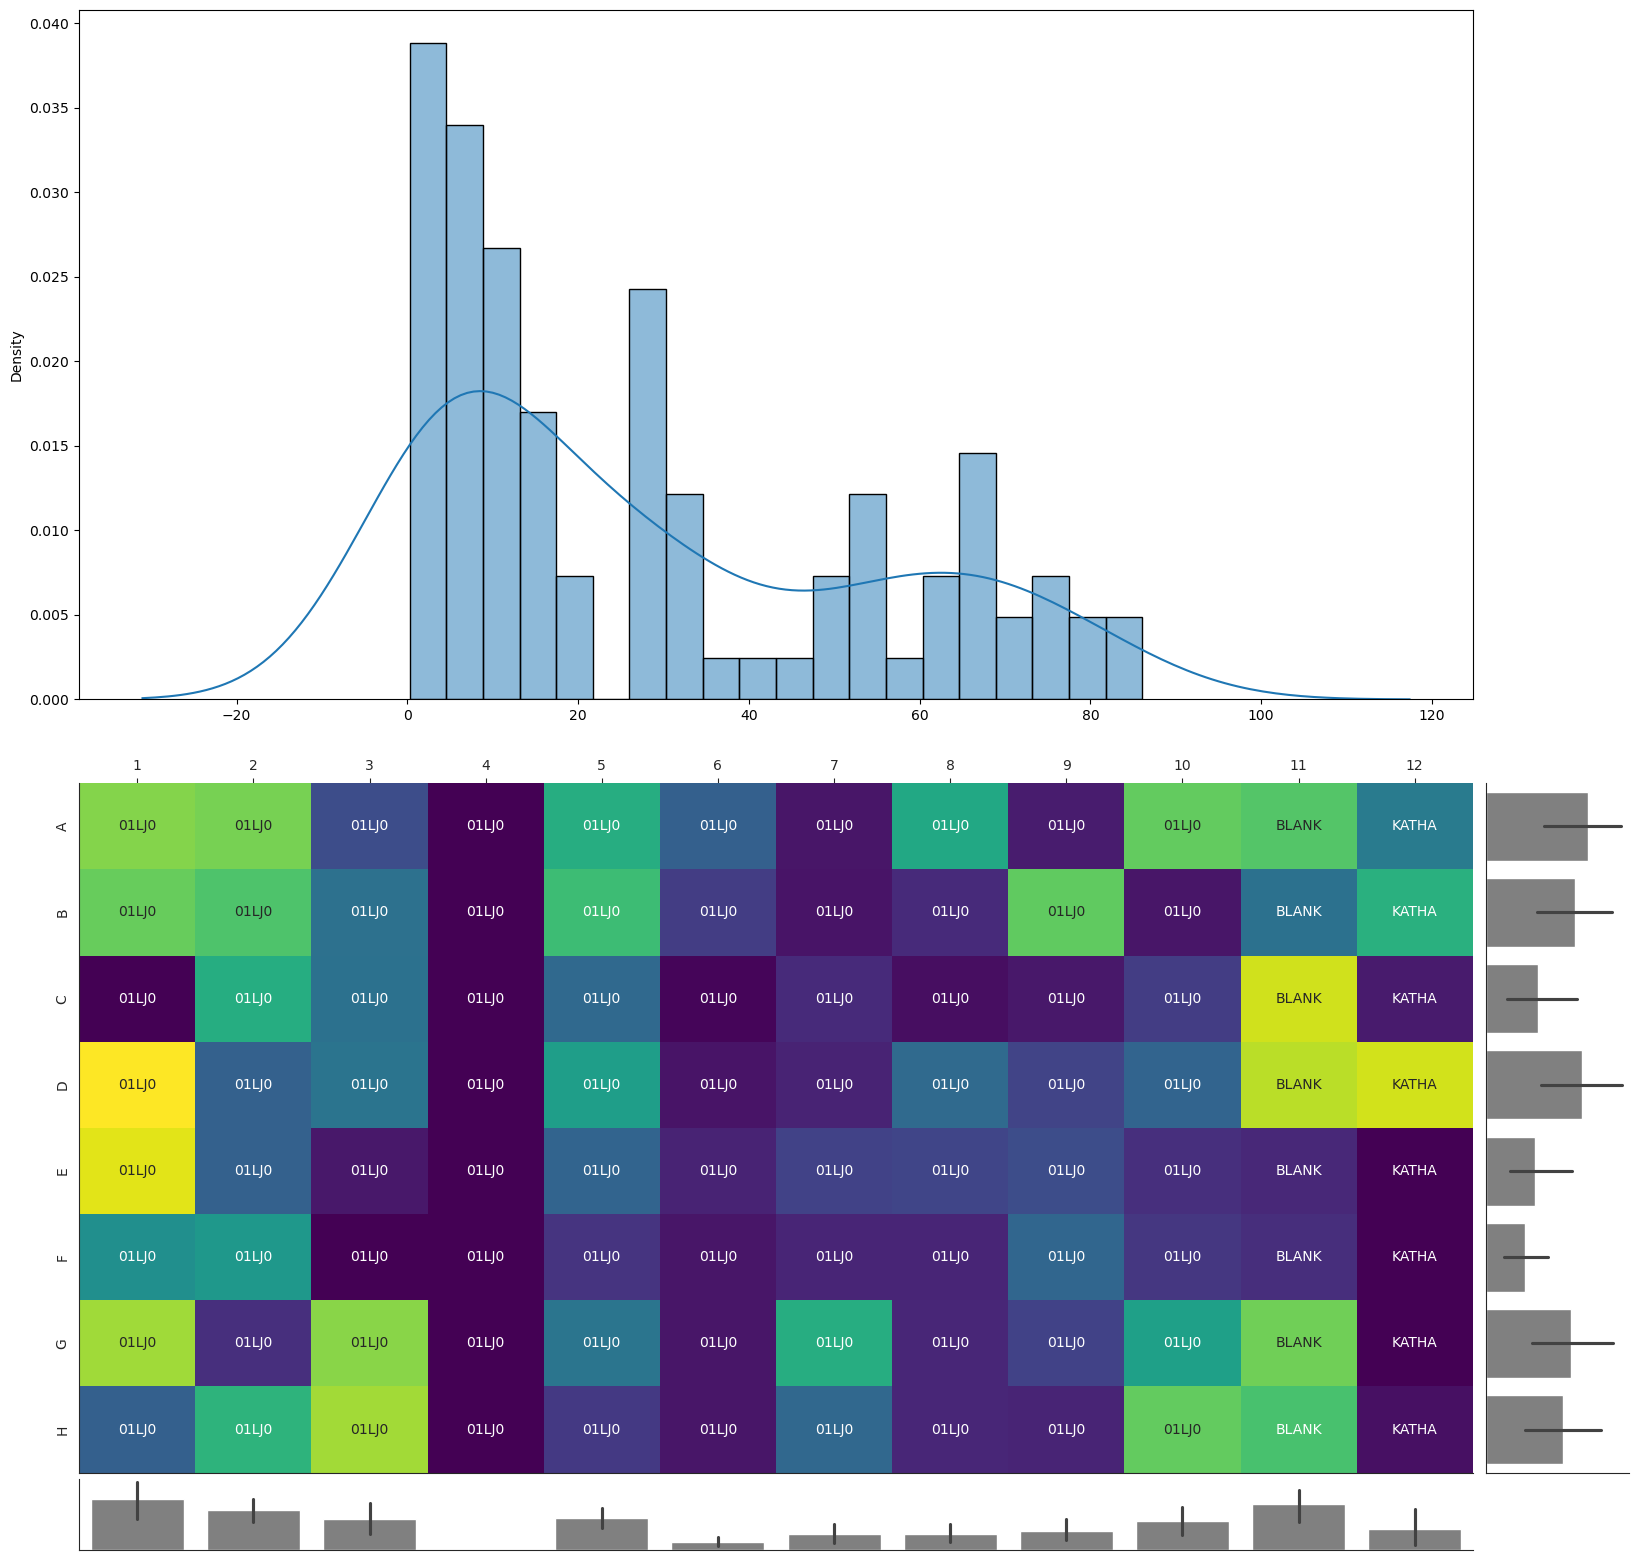

In [45]:
display_concentration_heatmap_by_dilution(plate_df, UNDILUTED_NAME, 3)


#### gDNA concentration heatmap, Plate 4

Concentration heatmap for undiluted plate 4


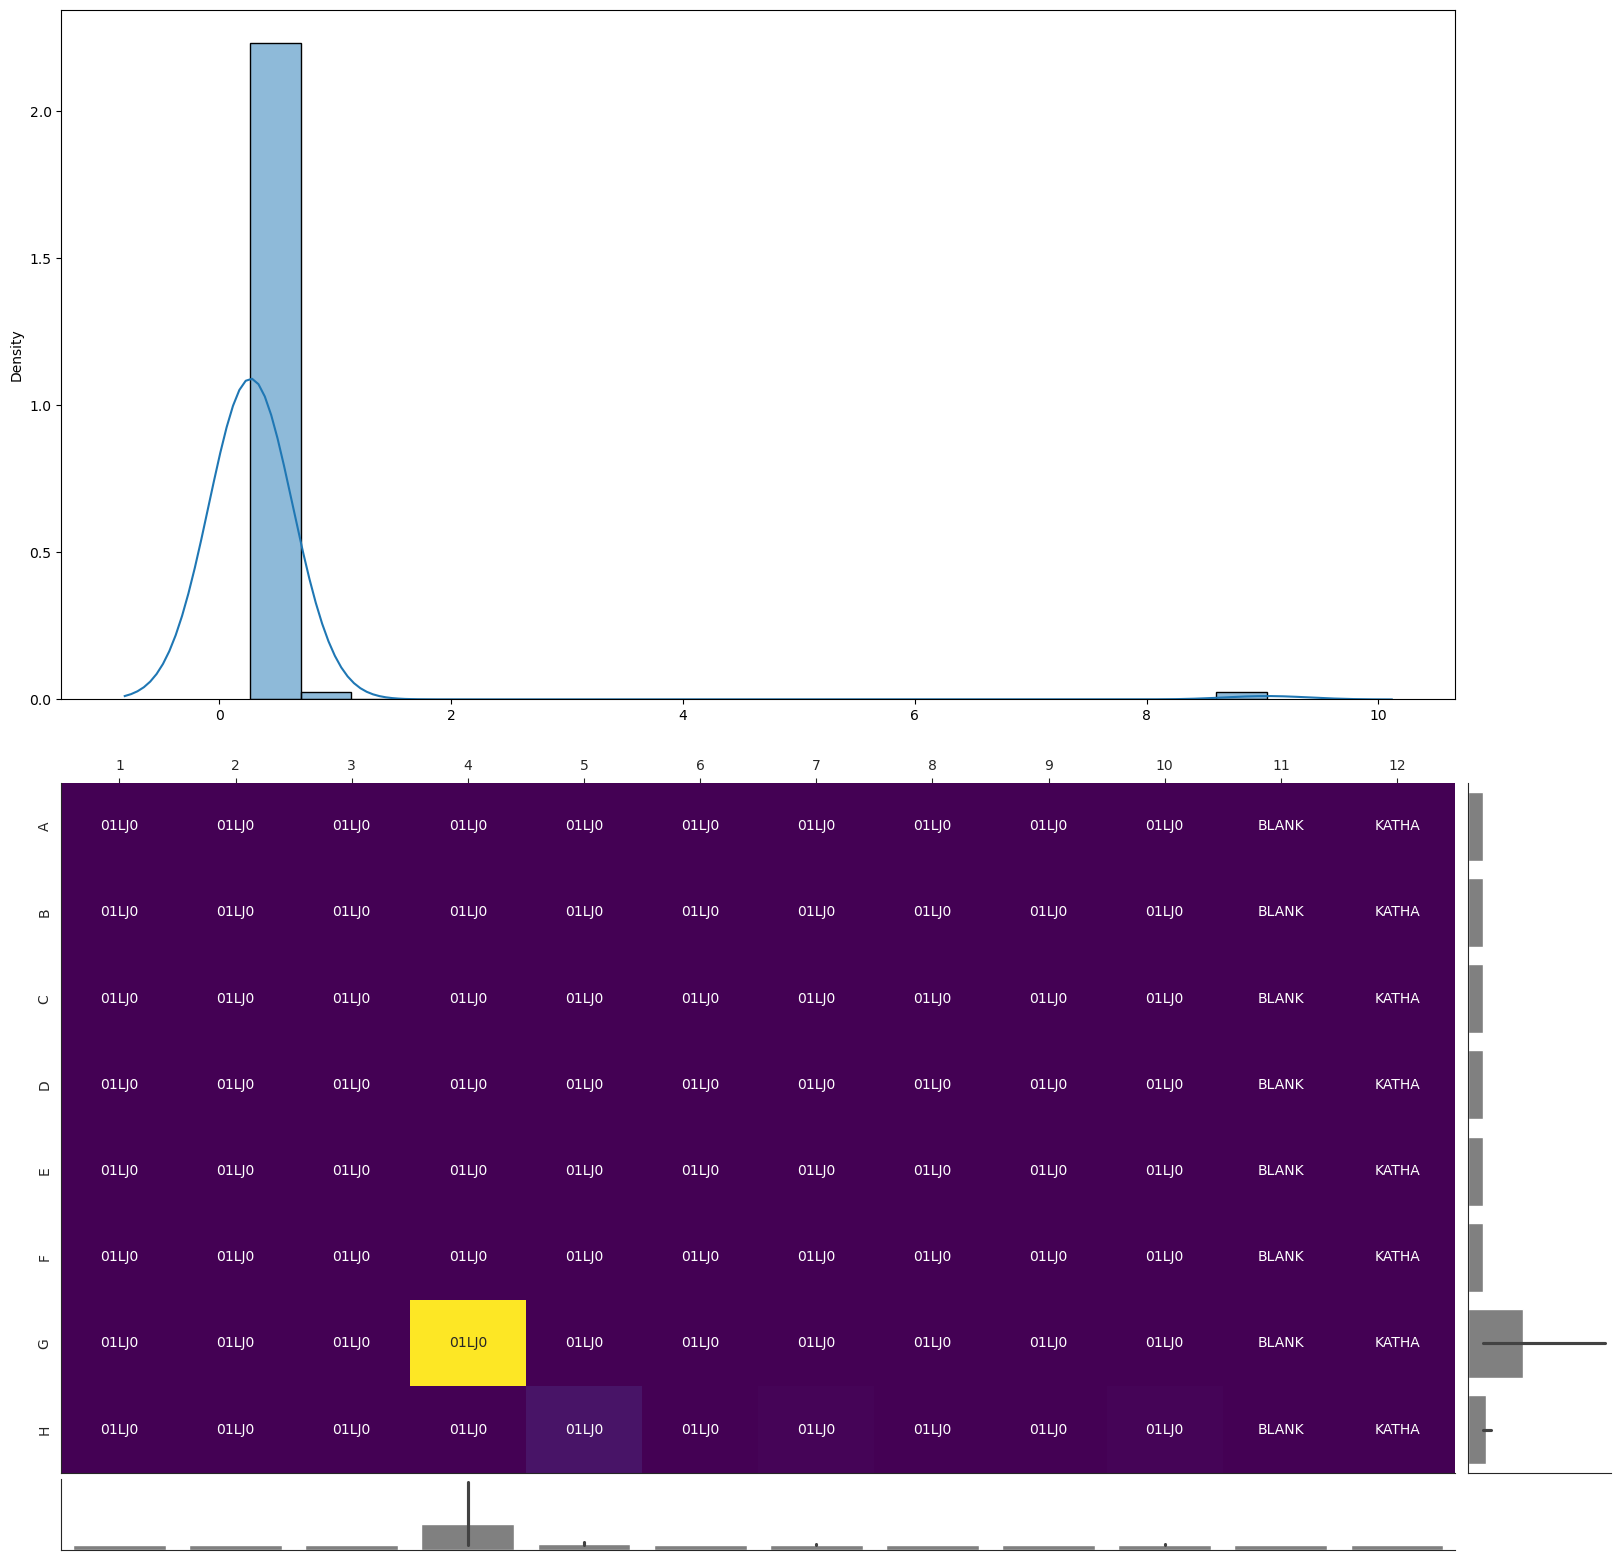

In [46]:
display_concentration_heatmap_by_dilution(plate_df, UNDILUTED_NAME, 4)

### Part 1 of 5, Step 6 of 8: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [47]:
## INPUT -- verify defaults
ng = 7.5
total_vol = 5000
min_vol = 25
resolution = 2.5

In [48]:
NORMALIZED_WATER_VOL_KEY = 'Normalized water volume'

dna_vols = calculate_norm_vol(
    plate_df[SAMPLE_DNA_CONC_KEY], ng=ng, min_vol=min_vol, 
    max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df[NORMALIZED_DNA_VOL_KEY] = dna_vols
plate_df[NORMALIZED_WATER_VOL_KEY] = water_vols
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Sample DNA Concentration_2to1dilution,Sample DNA Concentration_undiluted,extracted_gdna_concentration_ng_ul,Sample DNA Concentration,Diluted,dilution_factor_10to1dilution,Library Well,contains_replicates,Normalized DNA volume,Normalized water volume
0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,A,...,5.8560,11.712,11.712,5.8560,True,0.1,A1,False,1280.0,3720.0
1,01LJ00482.V8,2,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,A,...,7.1470,14.294,14.294,7.1470,True,0.1,A3,False,1050.0,3950.0
2,01LJ00482.V10,3,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,9.5235,19.047,19.047,1.9047,True,0.1,A5,False,3937.5,1062.5
3,01LJ00514.V8,4,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,13.6090,27.218,27.218,2.7218,True,0.1,A7,False,2755.0,2245.0
4,01LJ00514.V10,5,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_10to1dilution,Wellcome_Leap_Plate_1,A,...,11.2760,22.552,22.552,2.2552,True,0.1,A9,False,3325.0,1675.0


### Part 1 of 5, Step 7 of 8 (optional): Add synDNA spike-in

In [49]:
## INPUT
# Set syndna_pool_number to 1 if syndna is being used; otherwise, leave as None
syndna_pool_number = None
syndna_picklist_fp = './test_output/Input_Norm/Tellseq_matrix_syndna.txt'

In [50]:
plate_df = add_syndna(plate_df, 
                      syndna_pool_number=syndna_pool_number,
                      syndna_concentration=2.22)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1636: UserWarning: Returning input plate dataframe;no synDNA will be added to this prep
  warnings.warn("Returning input plate dataframe;"


In [51]:
f'For this plate, is_absquant = {is_absquant(plate_df)}'

'For this plate, is_absquant = False'

In [52]:
if is_absquant(plate_df):
    syndna_well='A1'
    syndna_plate = 'synDNA plate'
    syndna_picklist = \
        format_dna_norm_picklist(
            np.array(plate_df['synDNA volume']),
            np.zeros(plate_df.shape[0]),
            np.repeat(syndna_well,plate_df.shape[0]),
            dest_wells = np.array(plate_df[well_col]),
            sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
            sample_plates = np.repeat(syndna_plate,plate_df.shape[0]))

In [53]:
if is_absquant(plate_df):
    if os.path.isfile(syndna_picklist_fp):
        print("Warning! This file exists already.")

In [54]:
if is_absquant(plate_df):
    with open(syndna_picklist_fp, 'w') as f:
        f.write(syndna_picklist)

    !head {syndna_picklist_fp}

### Part 1 of 5, Step 8 of 8: Make pick list and write to file

Format the Echo-compatible pick list.

In [55]:
## INPUT
norm_picklist_fp = './test_output/Input_Norm/Tellseq_inputnorm.txt'

In [56]:
norm_picklist = format_dna_norm_picklist(
    np.array(plate_df[NORMALIZED_DNA_VOL_KEY]),
    np.array(plate_df[NORMALIZED_WATER_VOL_KEY]),
    np.array(plate_df[PM_WELL_KEY]),
    dest_wells = np.array(plate_df[well_col]),
    sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
    sample_plates = np.array(plate_df[PM_COMPRESSED_PLATE_NAME_KEY]),
    dna_concs = np.array(plate_df[SAMPLE_DNA_CONC_KEY]))

In [57]:
# Write the picklist as .txt
warn_if_fp_exists(norm_picklist_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/Input_Norm/Tellseq_inputnorm.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [58]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
01LJ00482.V5	Wellcome_Leap_15538_1_2_3_4_2to1dilution	384PP_AQ_BP2	A1	5.856	1280.0	NormalizedDNA	A1
01LJ00482.V8	Wellcome_Leap_15538_1_2_3_4_2to1dilution	384PP_AQ_BP2	A3	7.147	1050.0	NormalizedDNA	A3
01LJ00482.V10	Wellcome_Leap_15538_1_2_3_4_10to1dilution	384PP_AQ_BP2	A5	1.9047	3937.5	NormalizedDNA	A5
01LJ00514.V8	Wellcome_Leap_15538_1_2_3_4_10to1dilution	384PP_AQ_BP2	A7	2.7218	2755.0	NormalizedDNA	A7
01LJ00514.V10	Wellcome_Leap_15538_1_2_3_4_10to1dilution	384PP_AQ_BP2	A9	2.2552	3325.0	NormalizedDNA	A9
01LJ00514.V12	Wellcome_Leap_15538_1_2_3_4_undiluted	384PP_AQ_BP2	A11	1.315	5000.0	NormalizedDNA	A11
01LJ00615.V8	Wellcome_Leap_15538_1_2_3_4_2to1dilution	384PP_AQ_BP2	A13	2.404	3120.0	NormalizedDNA	A13
01LJ00615.V10	Wellcome_Leap_15538_1_2_3_4_10to1dilution	384PP_AQ_BP2	A15	2.093	3582.5	NormalizedDNA	A15
01LJ00615.V12	Wellcome_Leap_15538_1_2_3_4_2to1dilution	384PP_

## Part 2 (of 5): Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate_df dataframe (from previous step)
2. A tab-delimited tellseq barcode file, containing Well and Barcode_ID columns
3. The name of the tellseq barcode source plate

The workflow then:
1. reads in the tellseq barcode list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

### Part 2 of 5, Step 1 of 4: Read in tellseq barcode list

This is a file that contains each unique tellseq barcode on a separate line,
along with plate and well location information. It should look something like this:

```
Well,Barcode_96_Well_Position,Barcode_ID
A1,A1,C501
B1,A2,C509
C1,B1,C502
D1,B2,C510
E1,C1,C503
F1,C2,C511
G1,D1,C504
H1,D2,C512
I1,E1,C505
J1,E2,C513
K1,F1,C506
```

In [59]:
## INPUT
barcodes_plate_name = 'TellSeq_Barcode_Plate_1_LN2409001_EXP052026'
barcodes_fp = './test_data/Tellseq/TELL-Seq_Barcodes_PP_Primer_Plate - PP_Primer_Position.csv'

In [60]:
if not os.path.isfile(barcodes_fp):
    print("Problem! %s is not a path to a valid file" % barcodes_fp)

In [61]:
barcodes = pd.read_csv(barcodes_fp, dtype=str)

# rename the columns to match what `format_index_picklist` expects
# and add the plate information
barcodes.rename(columns={'Well': 'i5 well', 'Barcode_ID': 'i5 name'}, inplace=True)
barcodes['i5 plate'] = barcodes_plate_name
barcodes.head()

,i5 well,Barcode_96_Well_Position,i5 name,i5 plate
0,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026
1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026
2,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026
3,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026
4,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026


### Part 2 of 5, Step 2 of 4: Assign tellseq barcodes

In [62]:
def sort_by_col_then_row(a_df, well_key='Well'):
    # remove the first character from the contents of a_df[well_key] and 
    # store it in its own column named f"{well_key}_row"
    a_df[f"{well_key}_row"] = a_df[well_key].str[:1]
    
    # take everything BUT the first character in the contents of a_df[well_key]
    # and convert it to an integer and store it in its own column named
    # f"{well_key}_col"
    a_df[f"{well_key}_col"] = a_df[well_key].str[1:].astype(int)
    
    # sort the dataframe first by the column and then by the row
    a_df.sort_values(by=[f"{well_key}_col", f"{well_key}_row"], inplace=True)
    return a_df

def get_num_barcode_sets_needed(a_plate_df, barcodes_df):
    # if num_barcode_sets_needed is not an integer, throw an error
    num_barcode_sets_needed = a_plate_df.shape[0]/ barcodes_df.shape[0]
    if num_barcode_sets_needed % 1 != 0:
        raise ValueError(
            f"Number of barcodes ({barcodes_df.shape[0]}) "
            f"does not divide evenly into number of samples "
            f"]({a_plate_df.shape[0]})")
    return int(num_barcode_sets_needed)

In [63]:
# get the plate_df sorted by col then row
p_df = plate_df.copy()
p_df = sort_by_col_then_row(p_df, well_key=PM_LIB_WELL_KEY)
# make the existing index into a column and reindex
p_df.reset_index(inplace=True)

In [64]:
# get the barcodes sorted by col then row
b_df = barcodes.copy()
b_df = sort_by_col_then_row(b_df, well_key='i5 well')
b_df

,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col
0,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1
1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1
2,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1
3,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1
4,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1
...,...,...,...,...,...,...
91,L6,F12,C594,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,L,6
92,M6,G11,C587,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,M,6
93,N6,G12,C595,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,N,6
94,O6,H11,C588,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,O,6


In [65]:
# make a new barcodes_sets_df that duplicates the barcodes dataframe
# num_barcode_sets_needed times
concat_dfs = []
barcode_max_col = b_df['i5 well_col'].max()
num_barcode_sets = get_num_barcode_sets_needed(p_df, b_df)
curr_min_col = 0
curr_max_col = barcode_max_col
for i in range(num_barcode_sets):
    curr_set = b_df.copy()
    curr_set[TELLSEQ_BARCODE_SET_ID_KEY] = \
        f"col{curr_min_col + 1}to{curr_max_col}"
    curr_min_col = curr_max_col
    curr_max_col += barcode_max_col
    concat_dfs.append(curr_set)
barcode_sets_df = pd.concat(concat_dfs, ignore_index=True)
barcode_sets_df.head()

,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id
0,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6
1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6
2,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6
3,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6
4,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6


In [66]:
# merge the (sorted) plate_df and barcode_sets_df
p_df = pd.merge(p_df, barcode_sets_df, 
                    left_index=True, right_index=True)
p_df.set_index('index', inplace=True)
p_df[TELLSEQ_BARCODE_ID_KEY] = p_df['i5 name']
p_df

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Library Well_row,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id
index,,,,,,,,,,,,,,,,,,,,,
0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,A,...,A,1,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501
192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,A,...,B,1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509
12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,B,...,C,1,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502
204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,B,...,D,1,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510
24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,C,...,E,1,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,KATHARO.LEAP.4.12F.192,12,Wellcome_Leap_15538_1_2_3_4_undiluted,20240911,4,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_4_undiluted,Wellcome_Leap_Plate_4,F,...,L,24,L6,F12,C594,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,L,6,col19to24,C594
179,KATHARO.LEAP.2.12G.38,12,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,2,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_2_10to1dilution,Wellcome_Leap_Plate_2,G,...,M,24,M6,G11,C587,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,M,6,col19to24,C587
371,KATHARO.LEAP.4.12G.38,12,Wellcome_Leap_15538_1_2_3_4_undiluted,20240911,4,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_4_undiluted,Wellcome_Leap_Plate_4,G,...,N,24,N6,G12,C595,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,N,6,col19to24,C595


In [67]:
plate_df = p_df

### Part 2 of 5, Step 3 of 4: Make barcodes pick list and write to file

Format the Echo-compatible pick list.

In [68]:
## INPUT
barcode_picklist_fp = './test_output/Indices/Tellseq_barcode_matrix.txt'

## INPUT -- verify default
barcode_vol = 4000

In [69]:
barcode_picklist = format_index_picklist(
    plate_df[PM_SAMPLE_KEY], plate_df[well_col], barcode_sets_df,
    i5_vol=barcode_vol)

In [70]:
warn_if_fp_exists(barcode_picklist_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/Indices/Tellseq_barcode_matrix.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [71]:
with open(barcode_picklist_fp, 'w') as f:
    f.write(barcode_picklist)

!head {barcode_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Destination Plate Name	Destination Well
01LJ00482.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	A1	4000	C501	IndexPCRPlate	A1
01LJ01100.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	B1	4000	C509	IndexPCRPlate	B1
01LJ01597.V8	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	C1	4000	C502	IndexPCRPlate	C1
01LJ01315.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	D1	4000	C510	IndexPCRPlate	D1
01LJ02862.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	E1	4000	C503	IndexPCRPlate	E1
01LJ01447.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	F1	4000	C511	IndexPCRPlate	F1
01LJ04192.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	G1	4000	C504	IndexPCRPlate	G1
01LJ01600.V5	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	H1	4000	C512	IndexPCRPlate	H1
01LJ04877.V8	TellSeq_Barcode_Plate_1_LN2409001_EXP052026	384LDV_AQ_B2	I1	4000	

### Part 2 of 5, Step 4 of 4: Write plate and study info to files

We want to keep all that useful information together in one place so that
it can be easily parsed later. Enter the base (without extension) of the two output file names; the code will provide the extensions.

In [72]:
## INPUT
file_name_base = './test_output/QC/Tellseq'

In [73]:
plate_df_fp = f"{file_name_base}_plate_df_A.txt"
if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [74]:
plate_df.to_csv(plate_df_fp, sep='\t')

Save the experiment and study info so it doesn't have to be re-entered by hand in the next notebook.

In [75]:
expt_info_fp = f"{file_name_base}_expt_info.yml"
if os.path.isfile(expt_info_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [76]:
expt_info = {
    "experiment_name": expt_name,
    "studies": studies_info
}

In [77]:
with open(expt_info_fp, 'w') as file:
    yaml.dump(expt_info, file, default_flow_style=False)